In [2]:
import sys
import time
from os import listdir
import gzip

from collections import Counter
from itertools import chain, product

import numpy as np
from scipy import sparse
import random

In [5]:
chrom = '20'
m = 6
fkey = ('AU1274', 'AU1274202', 'AU1274201')
ped_file = '../data/160826.ped'
data_dir = '../split_gen_miss'
phase_dir = '../sherlock_phased'

sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
coord_file = '%s/chr.%s.gen.coordinates.npy' % (data_dir,  chrom)
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s' % chrom) in f and 'gen.npz' in f])

# genotype (pred, obs): cost
g_cost = {
	(-1, -1): 0,
	(-1, 0): 1,
	(-1, 1): 1,
	(-1, 2): 1,
	(0, -1): 0,
	(0, 0): 0,
	(0, 1): 1,
	(0, 2): 2,
	(1, -1): 0,
	(1, 0): 1,
	(1, 1): 0,
	(1, 2): 1,
	(2, -1): 0,
	(2, 0): 2,
	(2, 1): 1,
	(2, 2): 0
}

# From GRCh37.p13 https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh37.p13
chrom_lengths = {
	'1': 249250621,
	'2': 243199373,
	'3': 198022430,
	'4': 191154276,
	'5': 180915260,
	'6': 171115067,
	'7': 159138663,
	'8': 146364022,
	'9': 141213431,
	'10': 135534747,
	'11': 135006516,
	'12': 133851895,
	'13': 115169878,
	'14': 107349540,
	'15': 102531392,
	'16': 90354753,
	'17': 81195210,
	'18': 78077248,
	'19': 59128983,
	'20': 63025520,
	'21': 48129895,
	'22': 51304566,
	'X': 155270560,
	'Y': 59373566
}
chrom_length = chrom_lengths[chrom]

In [6]:
# pull families with sequence data
with open(sample_file, 'r') as f:
	sample_ids = [line.strip() for line in f]
sample_id_to_index = dict([(sample_id, i) for i, sample_id in enumerate(sample_ids)])

# pull families from ped file
families = dict()
with open(ped_file, 'r') as f:	
    for line in f:
        pieces = line.strip().split('\t')
        fam_id, child_id, f_id, m_id = pieces[0:4]

        if child_id in sample_ids and f_id in sample_ids and m_id in sample_ids:
        	if (fam_id, m_id, f_id) not in families:
        		families[(fam_id, m_id, f_id)] = [m_id, f_id]
        	families[(fam_id, m_id, f_id)].append(child_id)

# randomly permute children
families = dict([(k, x[:2]+random.sample(x[2:], len(x)-2)) for k, x in families.items()])
family_to_indices = dict([(fid, [sample_id_to_index[x] for x in vs]) for fid, vs in families.items()])
print('families with sequence data', len(families))

families_of_this_size = [(fkey, ind_indices) for fkey, ind_indices in family_to_indices.items() if len(ind_indices) == m]
print('families of size %d: %d' % (m, len(families_of_this_size)))

families with sequence data 886
families of size 6: 57


In [8]:
# inheritance states
#
# for parents:
# (0, 1) -> deletion on parental1
# (1, 0) -> deletion on parental2
# (1, 1) -> normal
# 
# for children:
# (0, 0) -> m1p1
# (0, 1) -> m1p2
# (1, 0) -> m2p1
# (1, 1) -> m2p2

if m >= 5:
	inheritance_states = np.array(list(product(*([[0, 1]]*(2*m)))), dtype=np.int8)
else:
	inheritance_states = np.array([x for x in product(*([[0, 1]]*(2*m))) if x[4]==0 and x[5]==0], dtype=np.int8)
state_to_index = dict([(tuple(x), i) for i, x in enumerate(inheritance_states)])
p, state_len = inheritance_states.shape
print('inheritance states', inheritance_states.shape)

inheritance states (4096, 12)


In [133]:
# pull genotype data from .npz
old_index_to_new_index = dict([(ind, i) for (i, ind) in enumerate(family_indices)])

whole_chrom = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file))[family_indices,:] for gen_file in gen_files])
	
# use only "cleaned" variants - must be SNPs and missingness in parents can't be sex-biased
snp_indices = []
snp_positions = []
with open(clean_file, 'r') as f:
    for i, line in enumerate(f):
        index, position = line.strip().split('\t')
        snp_indices.append(int(index))
        snp_positions.append(int(position))
snp_positions = np.array(snp_positions)

whole_chrom = whole_chrom[:, snp_indices]
total_inds, n = whole_chrom.shape
print('chrom shape only SNPs', total_inds, n)

chrom shape only SNPs 7 1567602


In [134]:
pos_to_index = dict([(x, i) for i, x in enumerate(snp_positions)])

In [135]:
deletions = -np.ones((8, 4, n))
inheritance = -np.ones((8, 10, n))
for family_size in range(3, 7):
    m = family_size
    print('Family size', m)
    # inheritance states
    #
    # for parents:
    # (0, 0) -> normal
    # (0, 1) -> deletion on parental2
    # (1, 0) -> deletion on parental1
    # (1, 1) -> deletion on parental1 and parental2
    # 
    # for children:
    # (0, 0) -> m1p1
    # (0, 1) -> m1p2
    # (1, 0) -> m2p1
    # (1, 1) -> m2p2

    if m >= 5:
        inheritance_states = np.array(list(product(*[[0, 1]]*(2*m))), dtype=np.int8)
    else:
        inheritance_states = np.array([x for x in product(*[[0, 1]]*(2*m)) if x[4] == 0 and x[5] == 0], dtype=np.int8)
    state_to_index = dict([(tuple(x), i) for i, x in enumerate(inheritance_states)])
    p, state_len = inheritance_states.shape
    print('inheritance states', inheritance_states.shape)

    # transition matrix
    # only allow one shift at a time
    shift_costs = [10]*4 + [100]*(2*(m-2))

    transitions = [[] for i in range(p)]
    transition_costs = [[] for i in range(p)]
    for i, state in enumerate(inheritance_states):
        # allow multiple deletion transitions
        for delstate in list(product(*[[0, 1]]*4)):
            new_state = tuple(delstate) + tuple(state[4:])
            new_index = state_to_index[new_state]
            transitions[i].append(new_index)
            transition_costs[i].append(sum([shift_costs[j] for j, (old_s, new_s) in enumerate(zip(state[:4], delstate)) if old_s != new_s]))

        # allow a single recombination event
        for j in range(4, inheritance_states.shape[1]):
            new_state = tuple(1-x if k == j else x for k, x in enumerate(state))
            if new_state in state_to_index:
                new_index = state_to_index[new_state]
                transitions[i].append(new_index)
                transition_costs[i].append(shift_costs[j])

    transitions = np.array(transitions)
    transition_costs = np.array(transition_costs)
    zero_transition_costs = inheritance_states[:, :6].dot(np.asarray(shift_costs, dtype=int)[:6])
    print('transitions', transitions.shape)

    # perfect match genotypes
    pm_gen_to_index = dict()
    pm_gen_indices = []
    for s in inheritance_states:
        pred_gens = np.zeros((anc_variants.shape[0], m), dtype=np.int8)

        # mom
        if s[0] == 0 and s[1] == 0:
            pred_gens[:, 0] = anc_variants[:, 0] + anc_variants[:, 1]
        elif s[0] == 0:
            pred_gens[:, 0] = 2*anc_variants[:, 0]
        elif s[1] == 0:
            pred_gens[:, 0] = 2*anc_variants[:, 1]
        else:
            pred_gens[:, 0] = -1*np.ones((anc_variants.shape[0],))

        # dad
        if s[2] == 0 and s[3] == 0:
            pred_gens[:, 1] = anc_variants[:, 2] + anc_variants[:, 3]
        elif s[2] == 0:
            pred_gens[:, 1] = 2*anc_variants[:, 2]
        elif s[3] == 0:
            pred_gens[:, 1] = 2*anc_variants[:, 3]
        else:
            pred_gens[:, 1] = -1*np.ones((anc_variants.shape[0],))

        # children
        for index in range(m-2):
            mat, pat = s[(4+(2*index)):(6+(2*index))]

            if s[mat] == 0 and s[2+pat] == 0:
                pred_gens[:, 2+index] = anc_variants[:, mat] + anc_variants[:, 2+pat]
            elif s[mat] == 0:
                pred_gens[:, 2+index] = 2*anc_variants[:, mat]
            elif s[2+pat] == 0:
                pred_gens[:, 2+index] = 2*anc_variants[:, 2+pat]
            else:
                pred_gens[:, 2+index] = -1*np.ones((anc_variants.shape[0],))

        unique_pred_gens = set(map(tuple, pred_gens))
        for pg in unique_pred_gens:
            if pg not in pm_gen_to_index:
                pm_gen_to_index[pg] = len(pm_gen_to_index)
        pm_gen_indices.append([pm_gen_to_index[pg] for pg in unique_pred_gens])

    pm_gen = np.zeros((len(pm_gen_to_index), m), dtype=np.int8)
    for pm, i in pm_gen_to_index.items():
        pm_gen[i, :] = pm
    print('perfect matches', pm_gen.shape, Counter([len(v) for v in pm_gen_indices]))

    def calculate_loss(gen): 
        s = np.zeros((len(pm_gen_to_index),), dtype=np.int8)
        for pm, i in pm_gen_to_index.items():
            s[i] = sum([g_cost[(pred, obs)] for pred, obs in zip(pm, gen)])

        d = np.zeros((p,), dtype=np.int8)
        for i, indices in enumerate(pm_gen_indices):
            d[i] = np.min(s[indices])
        return d

    genotypes = np.array(list(product(*[[-2, -1, 0, 1, 2]]*m)), dtype=np.int8)
    genotype_to_index = dict([(tuple(x), i) for i, x in enumerate(genotypes)])
    q = genotypes.shape[0]
    print('genotypes', genotypes.shape)

    losses = np.zeros((p, q), dtype=np.int8)
    for x in np.unique(whole_chrom.A, axis=1).T:
        g = tuple(x[:family_size])
        losses[:, genotype_to_index[g]] = calculate_loss(g)
    print('losses', losses.shape)

    inds = families[fkey]
    print('family', fkey)

    # pull genotype data for this family
    family_genotypes = whole_chrom[:family_size, :].A

    # condense repeated genotypes
    rep_indices = np.where(np.any(family_genotypes[:, 1:]!=family_genotypes[:, :-1], axis=0))[0]
    mult_factor = [rep_indices[0]+1] + (rep_indices[1:]-rep_indices[:-1]).tolist() + [family_genotypes.shape[1]-rep_indices[-1]-1]
    family_snp_positions = np.zeros((rep_indices.shape[0]+1, 2), dtype=int)
    family_snp_positions[1:, 0] = snp_positions[(rep_indices+1)]
    family_snp_positions[0, 0] = snp_positions[0]
    family_snp_positions[:-1, 1] = snp_positions[rep_indices]
    family_snp_positions[-1, 1] = snp_positions[-1]
    rep_indices = rep_indices.tolist()
    rep_indices.append(family_genotypes.shape[1]-1)
    n = len(rep_indices)

    # viterbi
    v_cost = np.zeros((p, n), dtype=int)
    
    # forward sweep
    prev_time = time.time()

    # first step, break symmetry
    # we enforce that the chromosome starts with child1 (0, 0) and no deletions
    pos_gen = tuple(family_genotypes[:, 0])
    loss = losses[:, genotype_to_index[pos_gen]].astype(int)
    v_cost[:, 0] = mult_factor[0]*loss + zero_transition_costs

    # next steps
    for j in range(1, n): 
        pos_gen = tuple(family_genotypes[:, rep_indices[j]])
        loss = losses[:, genotype_to_index[pos_gen]].astype(int)
        v_cost[:, j] = np.min(v_cost[transitions, j-1] + transition_costs, axis=1) + mult_factor[j]*loss
    print('Forward sweep complete', time.time()-prev_time, 'sec') 

    # backward sweep
    prev_time = time.time()
    final_states = -np.ones((state_len, n), dtype=int)

    # choose best paths
    # we enforce that the chromosome ends with no deletions
    num_forks = 0
    no_delstates = np.sum(inheritance_states[:, :4], axis=1)==0
    min_value = np.min(v_cost[no_delstates, -1])
    paths = np.where((v_cost[:, -1]==min_value) & no_delstates)[0]
    print('Num solutions', paths.shape, inheritance_states[paths, :])

    # combine path states into a single state (unknown values represented with -1)
    if paths.shape[0] == 1:
        final_states[:, -1] = inheritance_states[paths[0], :]
    else:
        num_forks += 1
        path_states = inheritance_states[paths, :]
        known_indices = np.all(path_states == path_states[0, :], axis=0)
        final_states[known_indices, -1] = path_states[0, known_indices]

    # now work backwards
    for j in reversed(range(n-1)):
        # traceback
        total_cost = v_cost[transitions[paths, :], j] + transition_costs[paths, :]
        min_value = np.min(total_cost, axis=1)
        new_paths = set()
        for i, k in enumerate(paths):
            min_indices = transitions[k, np.where(total_cost[i, :] == min_value[i])[0]]	
            new_paths.update(min_indices.tolist())
        paths = np.asarray(list(new_paths), dtype=int)

        # combine path states a single state (unknown values represented with -1)
        if paths.shape[0] == 1:
            final_states[:, j] = inheritance_states[paths[0], :]
        else:
            num_forks += 1
            path_states = inheritance_states[paths, :]
            known_indices = np.all(path_states == path_states[0, :], axis=0)
            final_states[known_indices, j] = path_states[0, known_indices]

    print('Num positions in fork', num_forks)
    print('Backward sweep complete', time.time()-prev_time, 'sec') 

    # if a parental chromosome isn't inherited, then we don't know if it has a deletion
    maternal_indices = range(4, state_len, 2)
    paternal_indices = range(5, state_len, 2)

    final_states[0, np.all(final_states[maternal_indices, :]!=0, axis=0)] = -1
    final_states[1, np.all(final_states[maternal_indices, :]!=1, axis=0)] = -1
    final_states[2, np.all(final_states[paternal_indices, :]!=0, axis=0)] = -1
    final_states[3, np.all(final_states[paternal_indices, :]!=1, axis=0)] = -1
    
    # write to file
    change_indices = [-1] + np.where(np.any(final_states[:, 1:]!=final_states[:, :-1], axis=0))[0].tolist()
    for j in range(1, len(change_indices)):
        s_start, s_end = change_indices[j-1]+1, change_indices[j]
        pos_start, pos_end = family_snp_positions[s_start, 0], family_snp_positions[s_end, 1]
        for k in range(4):
            deletions[family_size, k, pos_to_index[pos_start]:pos_to_index[pos_end]] = final_states[k, s_start]
        for k in range(4, 2*m):
            inheritance[family_size, k-4, pos_to_index[pos_start]:pos_to_index[pos_end]] = final_states[k, s_start]

    # last entry
    s_start, s_end = change_indices[-1]+1, family_snp_positions.shape[0]-1
    pos_start, pos_end = family_snp_positions[s_start, 0], family_snp_positions[s_end, 1]
    for k in range(4):
        deletions[family_size, k, pos_to_index[pos_start]:pos_to_index[pos_end]] = final_states[k, s_start]
    for k in range(4, 2*family_size):
        inheritance[family_size, k-4, pos_to_index[pos_start]:pos_to_index[pos_end]] = final_states[k, s_start]

Family size 3
inheritance states (16, 6)
transitions (16, 16)
perfect matches (40, 3) Counter({4: 6, 8: 4, 2: 4, 15: 1, 1: 1})
genotypes (125, 3)
losses (16, 125)
family ('AU1274', 'AU1274202', 'AU1274201')
Forward sweep complete 6.653231143951416 sec
Num solutions (1,) [[0 0 0 0 0 0]]
Num positions in fork 1039
Backward sweep complete 9.984218835830688 sec
Family size 4
inheritance states (64, 8)
transitions (64, 18)
perfect matches (110, 4) Counter({4: 24, 8: 16, 2: 16, 1: 4, 15: 2, 16: 2})
genotypes (625, 4)
losses (64, 625)
family ('AU1274', 'AU1274202', 'AU1274201')
Forward sweep complete 8.607693672180176 sec
Num solutions (1,) [[0 0 0 0 0 0 1 0]]
Num positions in fork 1267
Backward sweep complete 10.189051866531372 sec
Family size 5
inheritance states (1024, 10)
transitions (1024, 22)
perfect matches (328, 5) Counter({4: 384, 8: 256, 2: 256, 1: 64, 16: 48, 15: 16})
genotypes (3125, 5)
losses (1024, 3125)
family ('AU1274', 'AU1274202', 'AU1274201')
Forward sweep complete 72.42809

In [140]:
# pull in called deletions
with open('%s/chr.%s.familysize.7.phased.txt' % (phase_dir, chrom), 'r')  as f:
    next(f) # skip header
    for line in f:
        pieces = line.strip().split('\t')
        family_key = pieces[0]
        inheritance_state = list(map(int, pieces[1:15]))
        start_pos, end_pos = [int(x) for x in pieces[15:17]]
        start_index, end_index = pos_to_index[start_pos], pos_to_index[end_pos]
    
        if family_key == '.'.join(fkey):
            for k in range(4):
                deletions[7, k, start_index:end_index] = inheritance_state[k]
            for k in range(4, 14):
                inheritance[7, k-4, start_index:end_index] = inheritance_state[k]

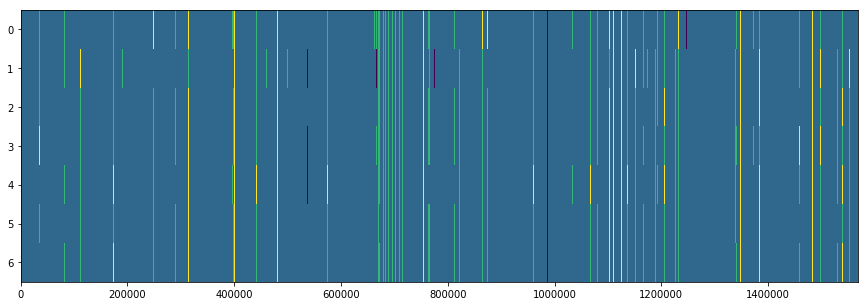

In [141]:
plt.figure(figsize=(15, 5))
plt.imshow(whole_chrom.A, aspect='auto', vmin=-1, vmax=2)
plt.show()

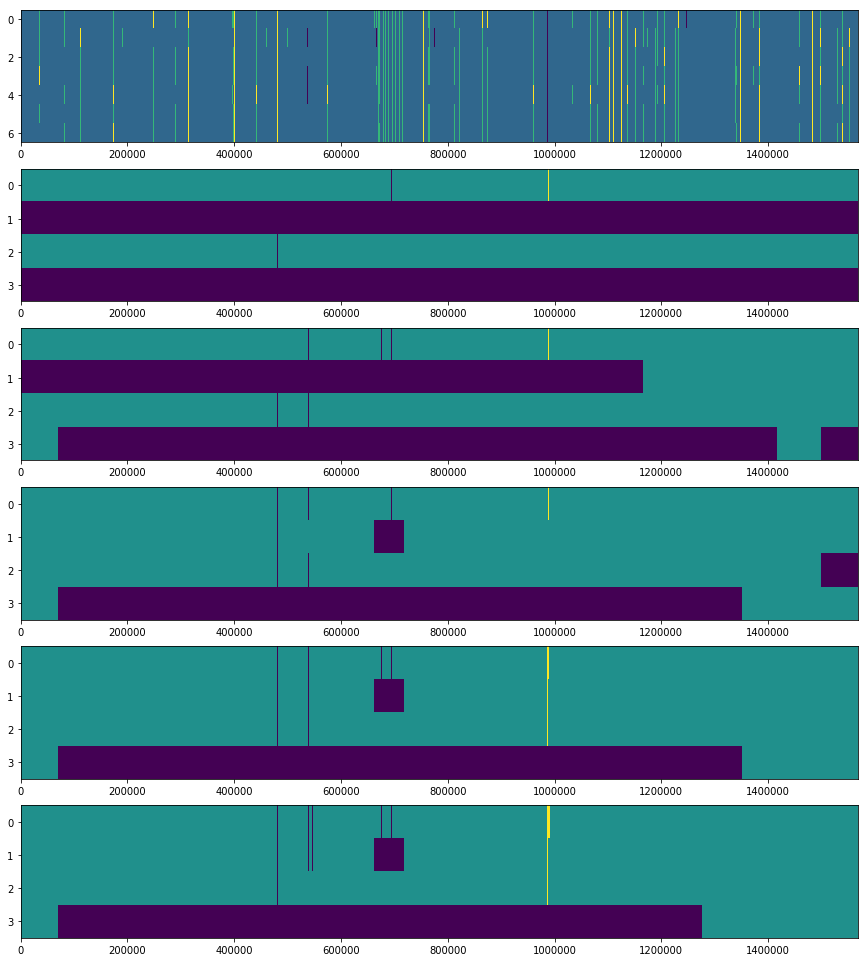

In [142]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 20))

plt.subplot(7, 1, 1)
plt.imshow(whole_chrom.A, aspect='auto', vmin=-1, vmax=2)

for i in range(3, 8):
    plt.subplot(7, 1, i-1)
    plt.imshow(deletions[i, :, :], aspect='auto', vmin=-1, vmax=1)

plt.show()

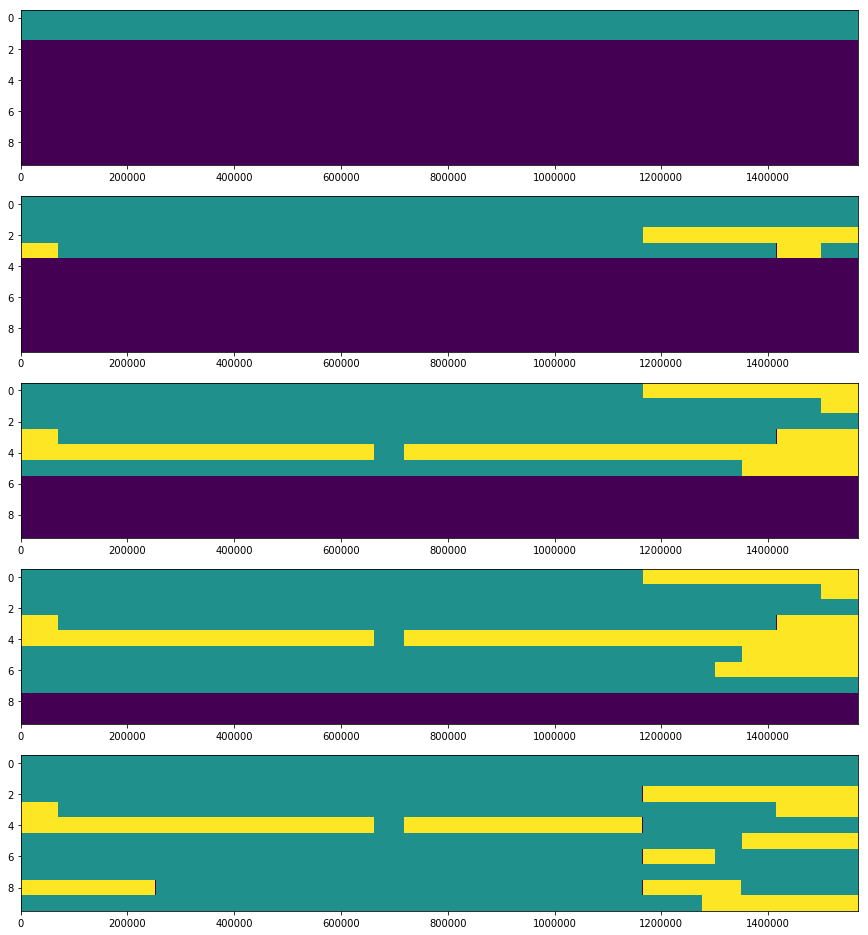

In [153]:
plt.figure(figsize=(15, 20))

for i in range(3, 8):
    plt.subplot(6, 1, i-2)
    plt.imshow(inheritance[i, :, :], aspect='auto', vmin=-1, vmax=1)

plt.show()

3 [[   4947.        242.          0.804       0.          0.953       0.047]
 [   1206.    3116454.          0.196       1.          0.          1.   ]]
4 [[   5736.       1400.          0.883       0.          0.804       0.196]
 [    760.    3671412.          0.117       1.          0.          1.   ]]
5 [[   7295.         58.          0.951       0.          0.992       0.008]
 [    375.    4838500.          0.049       1.          0.          1.   ]]
6 [[   7890.       0.       1.       0.       1.       0.]
 [      0. 4908113.       0.       1.       0.       1.]]


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


7 [[   7742.        563.          0.99        0.          0.932       0.068]
 [     82.    4901012.          0.01        1.          0.          1.   ]]


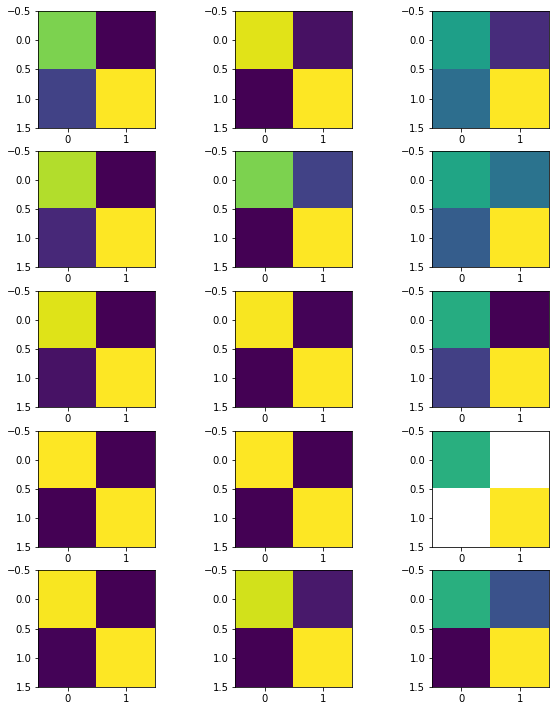

In [145]:
plt.figure(figsize=(10, 15))
s = 1
for i in range(3, 8):
    contingency = np.asarray([[np.sum((deletions[i, :, :]==1) & (deletions[6, :, :]==1)),
                   np.sum((deletions[i, :, :]==1) & (deletions[6, :, :]==0))],
                   [np.sum((deletions[i, :, :]==0) & (deletions[6, :, :]==1)),
                   np.sum((deletions[i, :, :]==0) & (deletions[6, :, :]==0))]])
    plt.subplot(6, 3, s)
    plt.imshow(contingency/np.sum(contingency, axis=0), vmin=0, vmax=1)
    s += 1
    plt.subplot(6, 3, s)
    plt.imshow((contingency.T/np.sum(contingency, axis=1)).T, vmin=0, vmax=1)
    s += 1
    plt.subplot(6, 3, s)
    plt.imshow(np.log10(contingency), vmin=2, vmax=5)
    s += 1
    np.set_printoptions(precision=3, suppress=True)
    print(i, np.hstack((contingency, contingency/np.sum(contingency, axis=0), (contingency.T/np.sum(contingency, axis=1)).T)))
plt.show()

In [226]:
print(whole_chrom.shape, deletions[7].shape)

(7, 88982) (7, 88982)


# Try just finding recombination points

In [152]:
family_size = 7
m = 7
print('Family size', m)
# inheritance states
#
# for parents:
# (0, 0) -> normal
# (0, 1) -> deletion on parental2
# (1, 0) -> deletion on parental1
# (1, 1) -> deletion on parental1 and parental2
# 
# for children:
# (0, 0) -> m1p1
# (0, 1) -> m1p2
# (1, 0) -> m2p1
# (1, 1) -> m2p2
inheritance_states = np.array([x for x in product(*[[0, 1]]*(2*m)) if x[0] == 0 and x[1] == 0 and x[2] == 0 and x[3] == 0 and x[4] == 0 and x[5] == 0], dtype=np.int8)
state_to_index = dict([(tuple(x), i) for i, x in enumerate(inheritance_states)])
p, state_len = inheritance_states.shape
print('inheritance states', inheritance_states.shape)

# transition matrix
# only allow one shift at a time
shift_costs = [10]*4 + [500]*(2*(m-2))

transitions = [[] for i in range(p)]
transition_costs = [[] for i in range(p)]
for i, state in enumerate(inheritance_states):
    # allow multiple deletion transitions
    for delstate in list(product(*[[0, 1]]*4)):
        new_state = tuple(delstate) + tuple(state[4:])
        if new_state in state_to_index:
            new_index = state_to_index[new_state]
            transitions[i].append(new_index)
            transition_costs[i].append(sum([shift_costs[j] for j, (old_s, new_s) in enumerate(zip(state[:4], delstate)) if old_s != new_s]))

    # allow a single recombination event
    for j in range(4, inheritance_states.shape[1]):
        new_state = tuple(1-x if k == j else x for k, x in enumerate(state))
        if new_state in state_to_index:
            new_index = state_to_index[new_state]
            transitions[i].append(new_index)
            transition_costs[i].append(shift_costs[j])

transitions = np.array(transitions)
transition_costs = np.array(transition_costs)
zero_transition_costs = inheritance_states[:, :6].dot(np.asarray(shift_costs, dtype=int)[:6])
print('transitions', transitions.shape)

# perfect match genotypes
# -1 = deletion
# 0 = ref allele
# 1 = alt allele
# 2 = duplication with both ref and alt allele
anc_variants_cnv = np.array(list(product(*[[-1, 0, 1]]*4)), dtype=np.int8)
print('ancestral variants cnv', anc_variants_cnv.shape)

pm_gen_to_index = dict()
pm_gen_indices = []
for s in inheritance_states:
    pred_gens = np.zeros((anc_variants_cnv.shape[0], m), dtype=np.int8)

    # mom
    # duplication
    pred_gens[(anc_variants_cnv[:, 0]==2) | (anc_variants_cnv[:, 1]==2), 0] = 1
    # deletion
    pred_gens[(anc_variants_cnv[:, 0]==-1) & (anc_variants_cnv[:, 1]==-1), 0] = -1
    pred_gens[(anc_variants_cnv[:, 0]==-1) & (anc_variants_cnv[:, 1]==0), 0] = 0
    pred_gens[(anc_variants_cnv[:, 0]==-1) & (anc_variants_cnv[:, 1]==1), 0] = 2
    pred_gens[(anc_variants_cnv[:, 0]==0) & (anc_variants_cnv[:, 1]==-1), 0] = 0
    pred_gens[(anc_variants_cnv[:, 0]==1) & (anc_variants_cnv[:, 1]==-1), 0] = 2
    # normal
    pred_gens[(anc_variants_cnv[:, 0]==0) & (anc_variants_cnv[:, 1]==0), 0] = 0
    pred_gens[(anc_variants_cnv[:, 0]==1) & (anc_variants_cnv[:, 1]==1), 0] = 2
    pred_gens[(anc_variants_cnv[:, 0]==0) & (anc_variants_cnv[:, 1]==1), 0] = 1
    pred_gens[(anc_variants_cnv[:, 0]==1) & (anc_variants_cnv[:, 1]==0), 0] = 1

    # dad
    # duplication
    pred_gens[(anc_variants_cnv[:, 2]==2) | (anc_variants_cnv[:, 3]==2), 1] = 1
    # deletion
    pred_gens[(anc_variants_cnv[:, 2]==-1) & (anc_variants_cnv[:, 3]==-1), 1] = -1
    pred_gens[(anc_variants_cnv[:, 2]==-1) & (anc_variants_cnv[:, 3]==0), 1] = 0
    pred_gens[(anc_variants_cnv[:, 2]==-1) & (anc_variants_cnv[:, 3]==1), 1] = 2
    pred_gens[(anc_variants_cnv[:, 2]==0) & (anc_variants_cnv[:, 3]==-1), 1] = 0
    pred_gens[(anc_variants_cnv[:, 2]==1) & (anc_variants_cnv[:, 3]==-1), 1] = 2
    # normal
    pred_gens[(anc_variants_cnv[:, 2]==0) & (anc_variants_cnv[:, 3]==0), 1] = 0
    pred_gens[(anc_variants_cnv[:, 2]==1) & (anc_variants_cnv[:, 3]==1), 1] = 2
    pred_gens[(anc_variants_cnv[:, 2]==0) & (anc_variants_cnv[:, 3]==1), 1] = 1
    pred_gens[(anc_variants_cnv[:, 2]==1) & (anc_variants_cnv[:, 3]==0), 1] = 1

    # children
    for index in range(m-2):
        mat, pat = s[(4+(2*index)):(6+(2*index))]
        
        # duplication
        pred_gens[(anc_variants_cnv[:, mat]==2) | (anc_variants_cnv[:, 2+pat]==2), 2+index] = 1
        # deletion
        pred_gens[(anc_variants_cnv[:, mat]==-1) & (anc_variants_cnv[:, 2+pat]==-1), 2+index] = -1
        pred_gens[(anc_variants_cnv[:, mat]==-1) & (anc_variants_cnv[:, 2+pat]==0), 2+index] = 0
        pred_gens[(anc_variants_cnv[:, mat]==-1) & (anc_variants_cnv[:, 2+pat]==1), 2+index] = 2
        pred_gens[(anc_variants_cnv[:, mat]==0) & (anc_variants_cnv[:, 2+pat]==-1), 2+index] = 0
        pred_gens[(anc_variants_cnv[:, mat]==1) & (anc_variants_cnv[:, 2+pat]==-1), 2+index] = 2
        # normal
        pred_gens[(anc_variants_cnv[:, mat]==0) & (anc_variants_cnv[:, 2+pat]==0), 2+index] = 0
        pred_gens[(anc_variants_cnv[:, mat]==1) & (anc_variants_cnv[:, 2+pat]==1), 2+index] = 2
        pred_gens[(anc_variants_cnv[:, mat]==0) & (anc_variants_cnv[:, 2+pat]==1), 2+index] = 1
        pred_gens[(anc_variants_cnv[:, mat]==1) & (anc_variants_cnv[:, 2+pat]==0), 2+index] = 1

    unique_pred_gens = set(map(tuple, pred_gens))
    for pg in unique_pred_gens:
        if pg not in pm_gen_to_index:
            pm_gen_to_index[pg] = len(pm_gen_to_index)
    pm_gen_indices.append([pm_gen_to_index[pg] for pg in unique_pred_gens])

pm_gen = np.zeros((len(pm_gen_to_index), m), dtype=np.int8)
for pm, i in pm_gen_to_index.items():
    pm_gen[i, :] = pm
print('perfect matches', pm_gen.shape, Counter([len(v) for v in pm_gen_indices]))

genotypes = np.array(list(product(*[[-2, -1, 0, 1, 2]]*m)), dtype=np.int8)
genotype_to_index = dict([(tuple(x), i) for i, x in enumerate(genotypes)])
q = genotypes.shape[0]
print('genotypes', genotypes.shape)

losses = np.zeros((p, q), dtype=np.int8)
already_calculated = np.zeros((q,), dtype=bool)
def calculate_loss(gen): 
    gen_index = genotype_to_index[tuple(gen)]
    if not already_calculated[gen_index]:
        s = np.zeros((len(pm_gen_to_index),), dtype=np.int8)
        for pm, i in pm_gen_to_index.items():
            s[i] = sum([g_cost[(pred, obs)] for pred, obs in zip(pm, gen)])
    
        for i, indices in enumerate(pm_gen_indices):
            losses[i, gen_index] = np.min(s[indices])
        already_calculated[gen_index] = True
    return losses[:, gen_index]


inds = families[fkey]
print('family', fkey)

# pull genotype data for this family
family_genotypes = whole_chrom[:family_size, :].A

# condense repeated genotypes
rep_indices = np.where(np.any(family_genotypes[:, 1:]!=family_genotypes[:, :-1], axis=0))[0]
mult_factor = [rep_indices[0]+1] + (rep_indices[1:]-rep_indices[:-1]).tolist() + [family_genotypes.shape[1]-rep_indices[-1]-1]
family_snp_positions = np.zeros((rep_indices.shape[0]+1, 2), dtype=int)
family_snp_positions[1:, 0] = snp_positions[(rep_indices+1)]
family_snp_positions[0, 0] = snp_positions[0]
family_snp_positions[:-1, 1] = snp_positions[rep_indices]
family_snp_positions[-1, 1] = snp_positions[-1]
rep_indices = rep_indices.tolist()
rep_indices.append(family_genotypes.shape[1]-1)
n = len(rep_indices)

# viterbi
v_cost = np.zeros((p, n), dtype=int)
    
# forward sweep
prev_time = time.time()

# first step, break symmetry
# we enforce that the chromosome starts with child1 (0, 0) and no deletions
pos_gen = tuple(family_genotypes[:, 0])
loss = calculate_loss(pos_gen).astype(int)
v_cost[:, 0] = mult_factor[0]*loss + zero_transition_costs

# next steps
for j in range(1, n): 
    pos_gen = tuple(family_genotypes[:, rep_indices[j]])
    loss = calculate_loss(pos_gen).astype(int)
    v_cost[:, j] = np.min(v_cost[transitions, j-1] + transition_costs, axis=1) + mult_factor[j]*loss
print('Forward sweep complete', time.time()-prev_time, 'sec') 

# backward sweep
prev_time = time.time()
final_states = -np.ones((state_len, n), dtype=int)

# choose best paths
# we enforce that the chromosome ends with no deletions
num_forks = 0
no_delstates = np.sum(inheritance_states[:, :4], axis=1)==0
min_value = np.min(v_cost[no_delstates, -1])
paths = np.where((v_cost[:, -1]==min_value) & no_delstates)[0]
print('Num solutions', paths.shape, inheritance_states[paths, :])

# combine path states into a single state (unknown values represented with -1)
if paths.shape[0] == 1:
    final_states[:, -1] = inheritance_states[paths[0], :]
else:
    num_forks += 1
    path_states = inheritance_states[paths, :]
    known_indices = np.all(path_states == path_states[0, :], axis=0)
    final_states[known_indices, -1] = path_states[0, known_indices]

# now work backwards
for j in reversed(range(n-1)):
    # traceback
    total_cost = v_cost[transitions[paths, :], j] + transition_costs[paths, :]
    min_value = np.min(total_cost, axis=1)
    new_paths = set()
    for i, k in enumerate(paths):
        min_indices = transitions[k, np.where(total_cost[i, :] == min_value[i])[0]]	
        new_paths.update(min_indices.tolist())
    paths = np.asarray(list(new_paths), dtype=int)

    # combine path states a single state (unknown values represented with -1)
    if paths.shape[0] == 1:
        final_states[:, j] = inheritance_states[paths[0], :]
    else:
        num_forks += 1
        path_states = inheritance_states[paths, :]
        known_indices = np.all(path_states == path_states[0, :], axis=0)
        final_states[known_indices, j] = path_states[0, known_indices]

print('Num positions in fork', num_forks)
print('Backward sweep complete', time.time()-prev_time, 'sec') 

# if a parental chromosome isn't inherited, then we don't know if it has a deletion
maternal_indices = range(4, state_len, 2)
paternal_indices = range(5, state_len, 2)

final_states[0, np.all(final_states[maternal_indices, :]!=0, axis=0)] = -1
final_states[1, np.all(final_states[maternal_indices, :]!=1, axis=0)] = -1
final_states[2, np.all(final_states[paternal_indices, :]!=0, axis=0)] = -1
final_states[3, np.all(final_states[paternal_indices, :]!=1, axis=0)] = -1
    
# write to file
change_indices = [-1] + np.where(np.any(final_states[:, 1:]!=final_states[:, :-1], axis=0))[0].tolist()
for j in range(1, len(change_indices)):
    s_start, s_end = change_indices[j-1]+1, change_indices[j]
    pos_start, pos_end = family_snp_positions[s_start, 0], family_snp_positions[s_end, 1]
    for k in range(4):
        deletions[family_size, k, pos_to_index[pos_start]:pos_to_index[pos_end]] = final_states[k, s_start]
    for k in range(4, 2*m):
        inheritance[family_size, k-4, pos_to_index[pos_start]:pos_to_index[pos_end]] = final_states[k, s_start]

# last entry
s_start, s_end = change_indices[-1]+1, family_snp_positions.shape[0]-1
pos_start, pos_end = family_snp_positions[s_start, 0], family_snp_positions[s_end, 1]
for k in range(4):
    deletions[family_size, k, pos_to_index[pos_start]:pos_to_index[pos_end]] = final_states[k, s_start]
for k in range(4, 2*family_size):
    inheritance[family_size, k-4, pos_to_index[pos_start]:pos_to_index[pos_end]] = final_states[k, s_start]

Family size 7
inheritance states (256, 14)
transitions (256, 9)
ancestral variants cnv (81, 4)
perfect matches (3520, 7) Counter({67: 150, 73: 60, 53: 30, 60: 15, 40: 1})
genotypes (78125, 7)
family ('AU1274', 'AU1274202', 'AU1274201')
Forward sweep complete 275.91774320602417 sec
Num solutions (1,) [[0 0 0 0 0 0 1 1 0 1 0 0 0 1]]
Num positions in fork 139
Backward sweep complete 9.948805809020996 sec
